# LANL Earthquakes Experiment
# Spectrogram Analysis

https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89

https://github.com/sevenfx/fastai_audio


TODO - external:
- q2q match of predictions distribution to "true" distribution.
- go on to transformers.

TODO - spectrogram:
- save images with a single channel (i.e. BW; can look in digits challenge in fastai for an example).
- understand how to work correctly with librosa (e.g. why the sample_rate changes the image rather than just changing the frequency axis scale).
- generate as good-looking images as I can. may use [[1]](https://www.kaggle.com/michael422/spectrogram-convolution),[[2]](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html),[[3]]().
   - but dont use naive differences as additional channels (if that's what the link does indeed), because the NN already does it well.

TODO - NN:
- classification: estimate MAE from confusion matrix (the sum error of a cell is its value X (distance from diagonal+0.5)).
- understand how to use interpreter to diagnose NN actions - actually look at images with stressed zones, but good images rather than "top losses" ones.
- regression - show errors efficiently: 1. fix error in interpreter [(maybe use this)](https://forums.fast.ai/t/cnn-regression/28968); 2. distribution of errors; 3. boxplot(true value, predicted value).
- normalize (in fastai or before it: just normalize the whole images together to mean 0 & sd 1; can try inside fastai and verify the mean was changed correctly; also understand what's imagenet_stats in fastai).
   - no need to reduce images sizes (better running time but shouldn't improve learning).
- use CV that respects buckets of segments. have a look at train_one() in zahar's code.
- duplicate data using overlap between segments (10/25/50K jump instead of 150K).
- try regularizations ([mixup](https://docs.fast.ai/callbacks.mixup.html), dropouts? (read; should be standard)).
- if looks good - go on to resnet50.
- add external (non-raw-signal) features.
   - find a way to extract the output of 1 or 2 layers before the final output (instead of the final output itself).
   - pass to Zahar a way to generate this "pre-output" as features for his model.
   - if possible - also pass to Zahar a way to train a network to generate these features (to allow features training with the same CV).
   - an alternative to 2 sequential models would be a single model with additional input in advanced layers - read about custom itemlist in fastai.


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
from pathlib import Path
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
import librosa
import librosa.display
from fastai.vision import *
from fastai.metrics import error_rate, mean_absolute_error

## Load and show data

In [2]:
n = int(150e3)
df = pd.read_csv('Data/train.csv', nrows=n, skiprows=None,
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

df_peak = pd.read_csv('Data/train.csv', nrows=int(150e3), skiprows=range(1,int(4.4e6)),
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
df_peak.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)

NameError: name 'pd' is not defined

In [4]:
print(df.head())
print(df.info())
print(df.describe())

   signal  quaketime
0      12     1.4691
1       6     1.4691
2       8     1.4691
3       5     1.4691
4       8     1.4691
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
signal       150000 non-null int16
quaketime    150000 non-null float64
dtypes: float64(1), int16(1)
memory usage: 1.4 MB
None
              signal      quaketime
count  150000.000000  150000.000000
mean        4.884113       1.450182
std         5.101106       0.011248
min       -98.000000       1.430797
25%         3.000000       1.440398
50%         5.000000       1.449999
75%         7.000000       1.459599
max       104.000000       1.469100


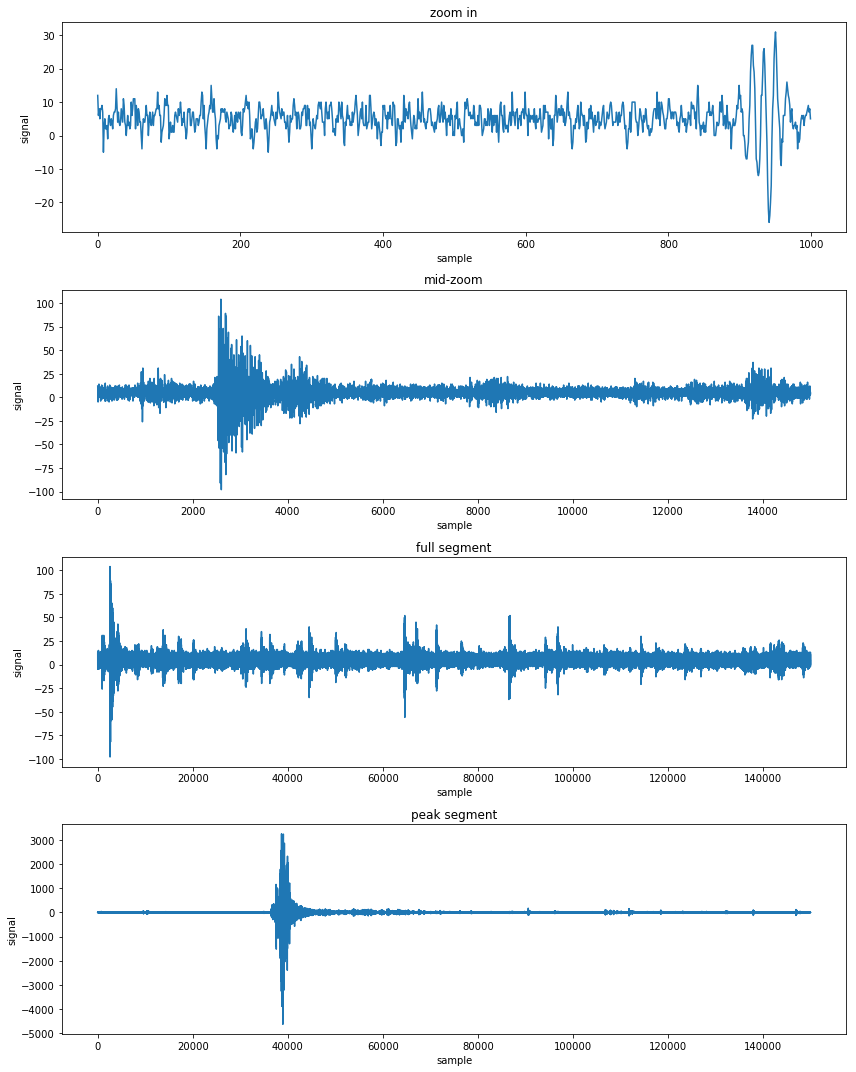

In [5]:
fig,axs = plt.subplots(4,1, figsize=(12,15))
axs[0].plot(df.signal.head(1000))
axs[1].plot(df.signal.head(15000))
axs[2].plot(df.signal.head(150000))
axs[3].plot(df_peak.signal)
for i,ax in enumerate(axs):
    ax.set_title(('zoom in','mid-zoom','full segment','peak segment')[i])
    ax.set_xlabel('sample')
    ax.set_ylabel('signal')
plt.tight_layout()

## Basic FFT
Note: there're suspected discontinuities in sampling times every 4096 samples ("batches"), so we find these discontinuities and compare batches FFTs with & without alignment to the discontinuity. Looks like the discontinuity does not noticably ruin the FFT, at least in the first 150K-samples segment.

In [6]:
def get_batches(df, verbose=True):
    dt = np.median(np.diff(-df.quaketime))
    transitions = np.where(np.logical_or(
        np.diff(-df.quaketime)>10*dt, np.diff(-df.quaketime)<-10*dt) )[0] + 1
    transitions = np.concatenate(([0], transitions, [len(df)]))
    if verbose:
        print('Distribution of blocks lengths:')
        l = [tf-ti for ti,tf in zip(transitions[:-1],transitions[1:])]
        print(tuple((g[0], len(list(g[1]))) for g in itertools.groupby(sorted(l))))
        print(f'Valid blocks (4096 samples):\t' +
              f'{np.sum(np.diff(transitions)==4096):.0f}/{len(l):d}')
    return transitions

transitions = get_batches(df)
transitions = get_batches(df_peak)

Distribution of blocks lengths:
((2545, 1), (4095, 1), (4096, 35))
Valid blocks (4096 samples):	35/37
Distribution of blocks lengths:
((3200, 1), (3440, 1), (4096, 35))
Valid blocks (4096 samples):	35/37


#### Standard segment

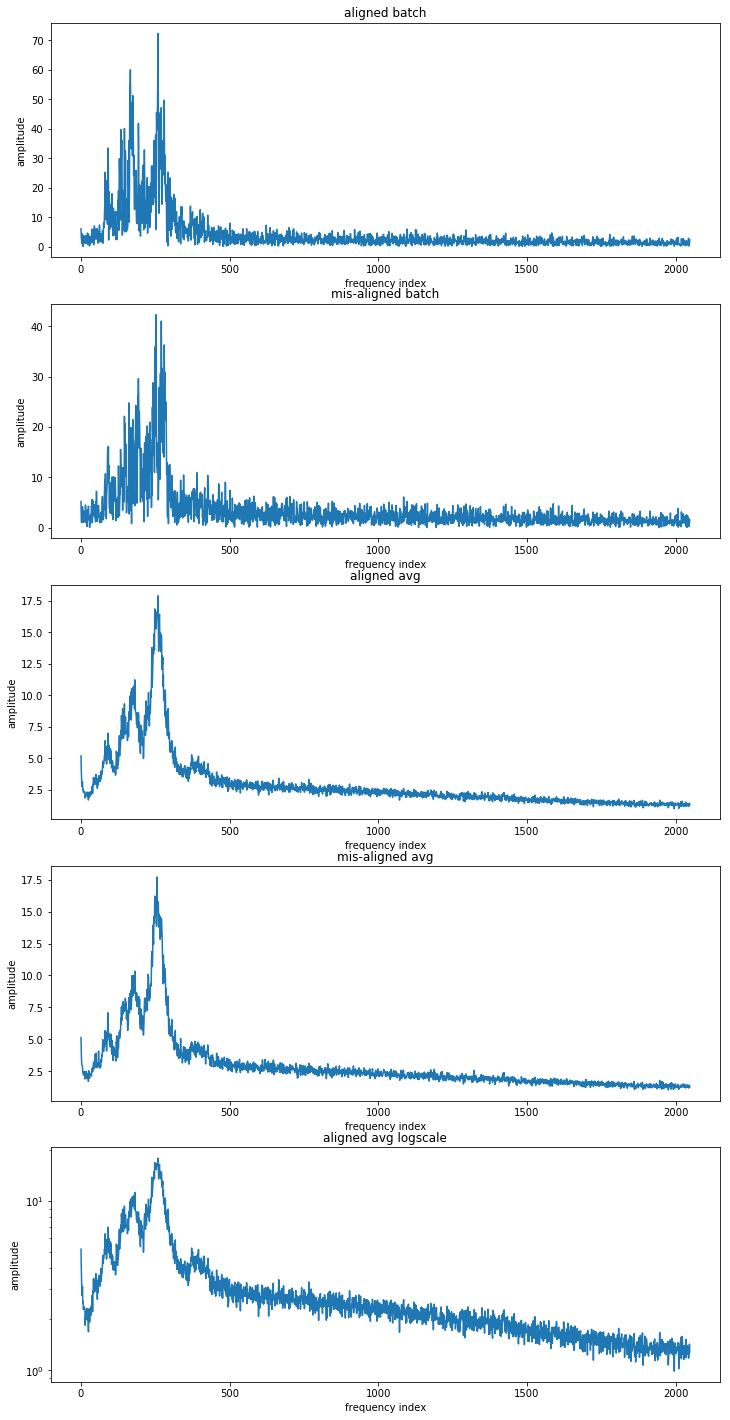

In [7]:
def batches_fft(df, transitions, offset=0):
    ffts = []
    for ti,tf in zip(transitions[:-1]+offset,transitions[1:]+offset):
        if tf-ti != 4096 or tf>=len(df): continue
        f = np.fft.rfft(df.signal[ti:tf], norm='ortho')[1:]
        ffts.append(np.abs(f))
    avg_fft = np.mean(ffts, axis=0)
    return (avg_fft, ffts)

ffts_aligned = batches_fft(df, transitions)
ffts_misaligned = batches_fft(df, transitions, 1000)

fig,axs = plt.subplots(5,1, figsize=(12,25))
axs[0].plot(ffts_aligned[1][0])
axs[1].plot(ffts_misaligned[1][0])
axs[2].plot(ffts_aligned[0])
axs[3].plot(ffts_misaligned[0])
axs[4].plot(ffts_aligned[0])
axs[4].set_yscale('log')
titles = ('aligned batch','mis-aligned batch','aligned avg','mis-aligned avg','aligned avg logscale')
for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel('frequency index')
    ax.set_ylabel('amplitude')

#### Peak segment

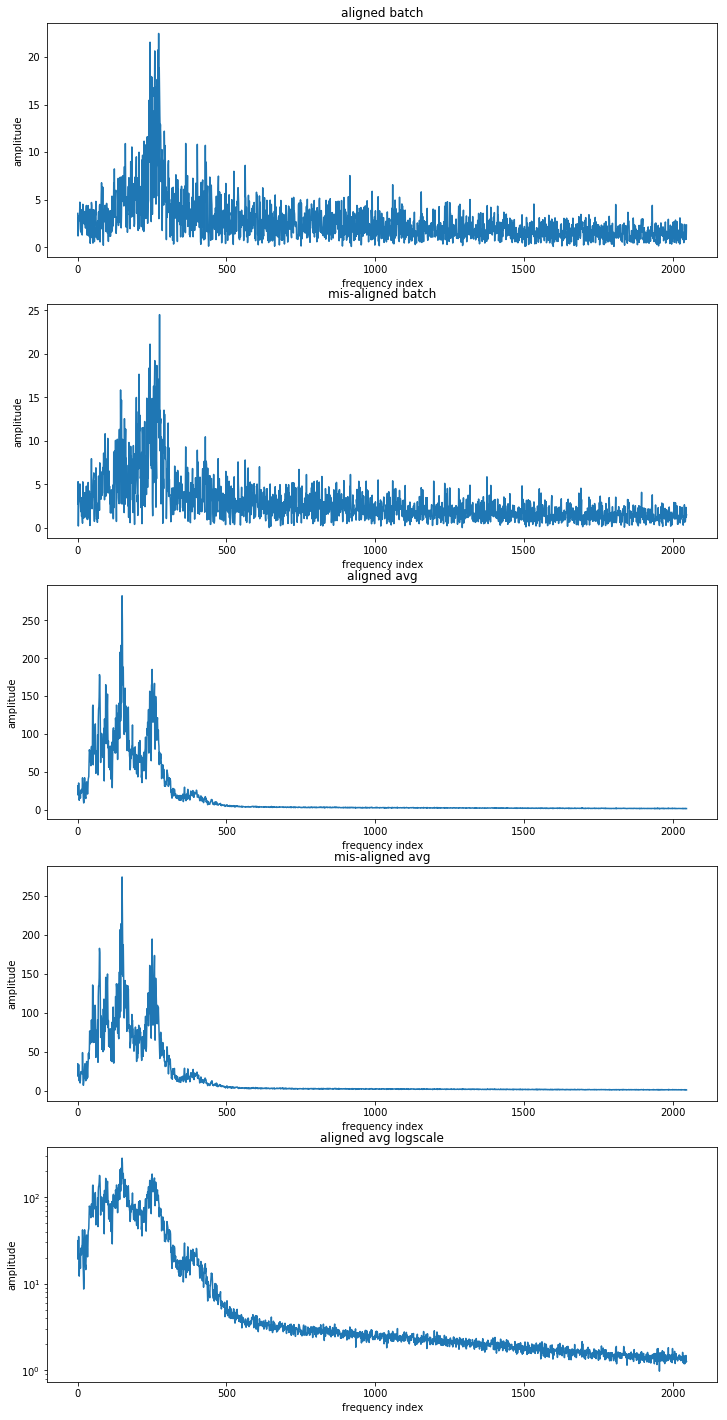

In [8]:
ffts_aligned = batches_fft(df_peak, transitions)
ffts_misaligned = batches_fft(df_peak, transitions, 1000)

fig,axs = plt.subplots(5,1, figsize=(12,25))
axs[0].plot(ffts_aligned[1][0])
axs[1].plot(ffts_misaligned[1][0])
axs[2].plot(ffts_aligned[0])
axs[3].plot(ffts_misaligned[0])
axs[4].plot(ffts_aligned[0])
axs[4].set_yscale('log')
titles = ('aligned batch','mis-aligned batch','aligned avg','mis-aligned avg','aligned avg logscale')
for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.set_xlabel('frequency index')
    ax.set_ylabel('amplitude')

## Spectrogram

Check linear vs. log frequency & linear vs. log power, in both "standard" and "peak" segments.

log power and log frequency look like the best images.

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


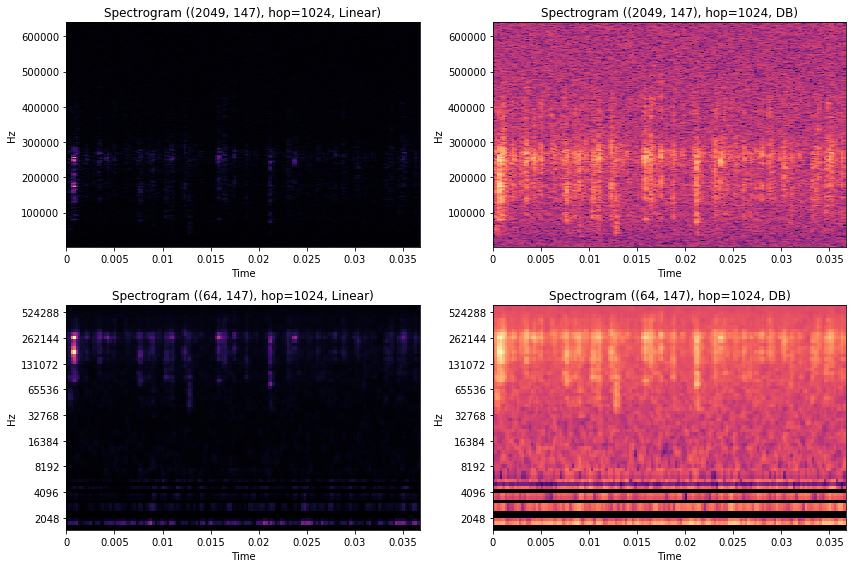

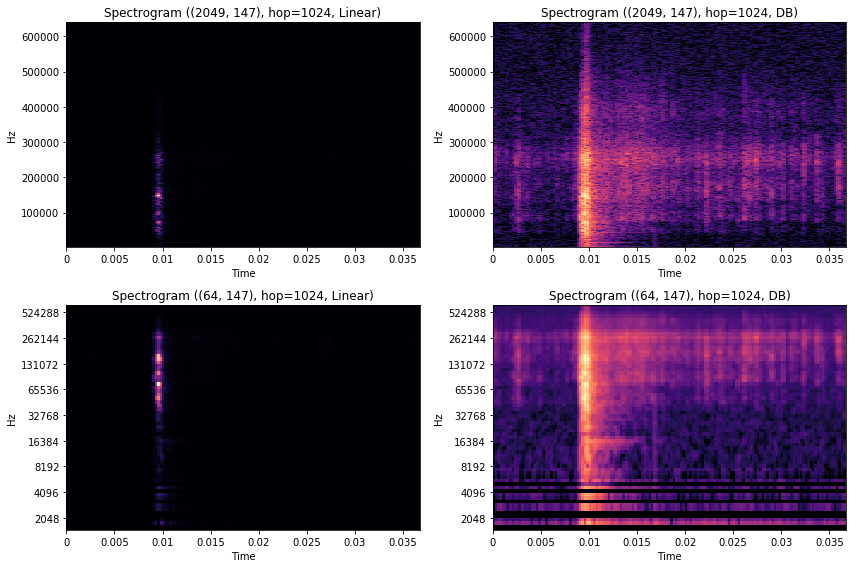

In [9]:
# Note - alternative plot code: plt.specgram(np.array(df.signal,dtype='float'), NFFT=4096, noverlap=2048, Fs=4096e3)
def plot_spec(df, n_fft=4096, hop_length=1024, sr=4096e3, n_mels=64, fmin=1480, fmax=640e3):
    stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, stft_phase = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)

    fig,axs = plt.subplots(2,2, figsize=(12,8))
    librosa.display.specshow(stft_magnitude, ax=axs[0,0], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,0].set_ylim((fmin,fmax))
    axs[0,0].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, Linear)')

    librosa.display.specshow(stft_magnitude_db, ax=axs[0,1], x_axis='time', y_axis='linear', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[0,1].set_ylim((fmin,fmax))
    axs[0,1].set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d}, DB)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    librosa.display.specshow(mel_spec, ax=axs[1,0], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,0].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, Linear)')

    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                              n_mels=n_mels, sr=sr, power=1.0,
                                              fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_spec, ax=axs[1,1], x_axis='time', y_axis='mel', 
                             sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
    axs[1,1].set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d}, DB)')
    
    plt.tight_layout()

plot_spec(df)
plot_spec(df_peak)

Certain parameters were chosen after several tries.

However, no reasonable parameters managed to prevent the black horizontal lines in the images.
These lines were found to be caused by high sample rate (~40MHz), even though I can't understand how this rate would affect the image (beside stretching the frequency axis).

Thus, below I fictively change the reported sample rate to 2 just for a nice visible image (since the scales are meaningless).
In future the parameters are planned to be correctly set with no such patches...

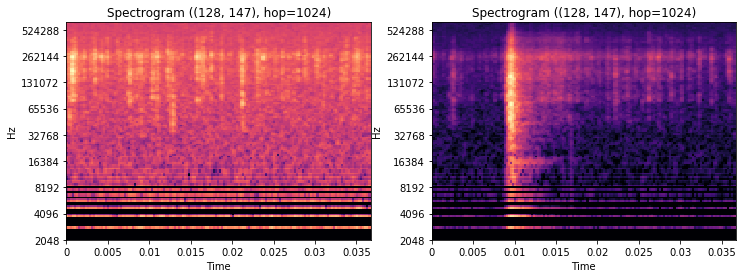

In [10]:
def plot_spec(dfs, n_fft=4096, hop_length=1024, sr=4096e3, n_mels=128, fmin=2048, fmax=640e3, power=1.0, lin=False):
    fig,axs = plt.subplots(1+lin,len(dfs), figsize=(6*len(dfs),4+4*lin))
    for i,df in enumerate(dfs):
        ax = axs[0,i] if lin else axs[i]
        mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                                  n_mels=n_mels, sr=sr, power=power, fmin=fmin, fmax=fmax)
        mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(mel_spec, ax=ax, x_axis='time', y_axis='mel', 
                                 sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
        ax.set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d})')
        
        if lin:
            ax = axs[1,i]
            stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
            stft_magnitude, stft_phase = librosa.magphase(stft)
            stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
            librosa.display.specshow(stft_magnitude_db, ax=ax, x_axis='time', y_axis='linear', 
                                     sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
            ax.set_ylim((fmin,fmax))
            ax.set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d})')


plot_spec((df,df_peak), n_fft=4096, hop_length=1024, n_mels=128)

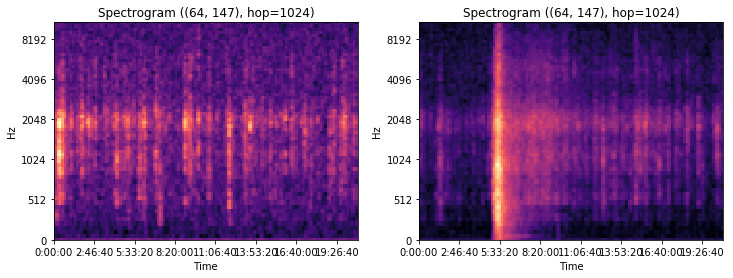

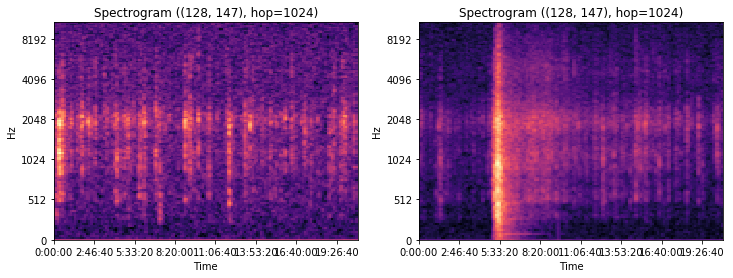

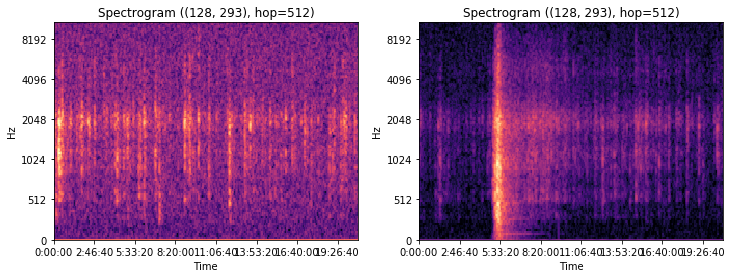

In [11]:
def plot_spec_with_hated_lib(dfs, n_fft=4096, hop_length=1024, sr=2, n_mels=256, power=1.0, lin=False):
    fig,axs = plt.subplots(1+lin,len(dfs), figsize=(6*len(dfs),4+4*lin))
    for i,df in enumerate(dfs):
        ax = axs[0,i] if lin else axs[i]
        mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                                  n_mels=n_mels, sr=sr, power=power)
        mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
        mel_spec = mel_spec[:mel_spec.shape[0]//4,:]
        librosa.display.specshow(mel_spec, ax=ax, x_axis='time', y_axis='mel', 
                                 sr=sr, hop_length=hop_length)
        ax.set_title(f'Spectrogram ({mel_spec.shape}, hop={hop_length:d})')
        
        if lin:
            ax = axs[1,i]
            stft = librosa.stft(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length)
            stft_magnitude, stft_phase = librosa.magphase(stft)
            stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
            librosa.display.specshow(stft_magnitude_db, ax=ax, x_axis='time', y_axis='linear', 
                                     sr=sr, hop_length=hop_length, fmin=fmin, fmax=fmax)
            ax.set_ylim((fmin,fmax))
            ax.set_title(f'Spectrogram ({stft_magnitude_db.shape}, hop={hop_length:d})')


plot_spec_with_hated_lib((df,df_peak), n_fft=4096, hop_length=1024, n_mels=256, power=1.)
plot_spec_with_hated_lib((df,df_peak), n_fft=4096, hop_length=1024, n_mels=512, power=1.)
plot_spec_with_hated_lib((df,df_peak), n_fft=2048, hop_length=512, n_mels=512, power=1.)

Eventually, the following parameters were chosen by visual judgement:

sample rate = 2,
n_fft = 2048,
hop_length = 512,
n_mels = 512,

## Prepare NN input

Read full train data - deprecated.

In [12]:
# df_full = pd.read_csv('Data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}, nrows=None)
# df_full.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
# print(df_full.shape)

# plt.figure()
# plt.hist(df_full.quaketime)

# plt.figure()
# stats.probplot(df_full.quaketime, dist="uniform", plot=plt)
# plt.grid()

Read train data in 4 chunks of 1K segments;
save each segment's spectrogram (as png file);
and keep a table of segments and their quaketimes:

In [13]:
BASE = Path('Data')
TRAIN = BASE/'train_spec'

n_all = 629145480 # df_full.shape[0] # 629145480
seg_len = int(150e3)
n_segs = int(n_all/seg_len)
segs_to_read = 1050

meta = pd.DataFrame(columns=('filename','time','class'))

def save_spec(df, seg_index, meta, class_limits=(0,1,2,3,4,5,6,7,8,10,12,99), base_path=Path('Data/train_spec'),
              n_fft=2048, hop_length=512, sr=2, n_mels=512, power=1.0):#, fmin=1480, fmax=640e3):
    tf = df.quaketime.values[-1]
    cls = np.where([a<=tf<b for a,b in zip(class_limits[:-1],class_limits[1:])])[0][0]
    cls_nm = '-'.join((f'{class_limits[cls]:02d}',f'{class_limits[cls+1]:02d}'))
    fname = str(seg_index) + '_' + cls_nm + '.png'
    meta.loc[i] = [fname, tf, cls_nm]
    
    mel_spec = librosa.feature.melspectrogram(np.array(df.signal,dtype='float'), n_fft=n_fft, hop_length=hop_length,
                                                  n_mels=n_mels, sr=sr, power=power)#, fmin=fmin, fmax=fmax)
    mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    mel_spec = mel_spec[:mel_spec.shape[0]//4,:]
    plt.imsave(base_path/fname, mel_spec)


for i in tqdm_notebook(range(n_segs)):
    #save_spec(df_full[i*seg_len:(i+1)*seg_len], i, meta)
    if i%segs_to_read==0:
        tmp = pd.read_csv(BASE/'train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                          nrows=seg_len*segs_to_read, skiprows=range(1,1+i*seg_len))
        tmp.rename(columns={'acoustic_data': 'signal', 'time_to_failure': 'quaketime'}, inplace=True)
    save_spec(tmp[(i%segs_to_read)*seg_len:((i%segs_to_read)+1)*seg_len], i, meta)

meta.to_csv('Data/train_spec_meta.csv')
meta.head()

,filename,time,class
0,0_01-02.png,1.430797,01-02
1,1_01-02.png,1.391499,01-02
2,2_01-02.png,1.353196,01-02
3,3_01-02.png,1.313798,01-02
4,4_01-02.png,1.274400,01-02


## Classification

In [14]:
meta = pd.read_csv(BASE/'train_spec_meta.csv')
#data = ImageDataBunch.from_df('Data/train_spec/tmp',
#                               meta2[['i','class']].iloc[[0,6,29,325]], size=(128,293), bs=4)#.normalize(imagenet_stats)
data = ImageDataBunch.from_df(TRAIN,  meta[['filename','class']], size=(128,293), bs=16)
data

ImageDataBunch;

Train: LabelList (3356 items)
x: ImageList
Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293)
y: CategoryList
01-02,01-02,01-02,01-02,01-02
Path: ..\Data\train_spec;

Valid: LabelList (838 items)
x: ImageList
Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293)
y: CategoryList
04-05,03-04,12-99,07-08,03-04
Path: ..\Data\train_spec;

Test: None

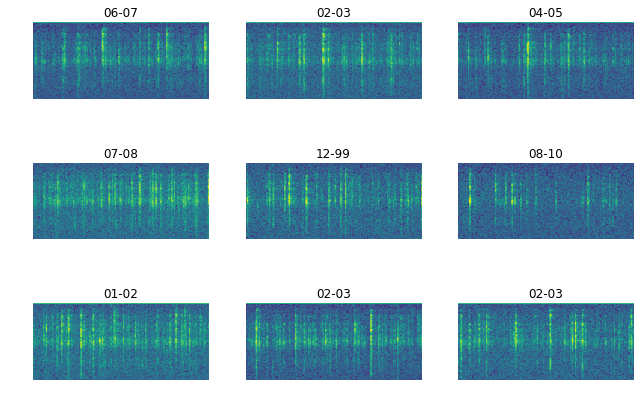

In [15]:
data.show_batch(rows=3, figsize=(9,6))

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [18]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.616223,2.367694,0.835322,03:28
1,2.320477,2.232523,0.853222,03:16
2,2.090243,2.230531,0.818616,03:11
3,1.889265,2.225994,0.826969,03:11


In [20]:
learn.save('model_spec_class_resnet34_freezed')

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

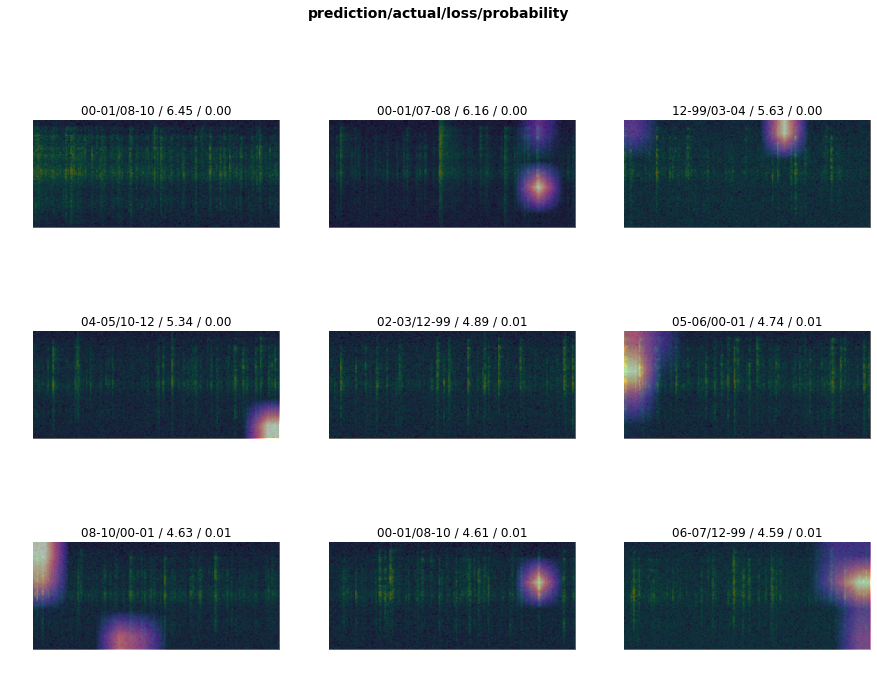

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

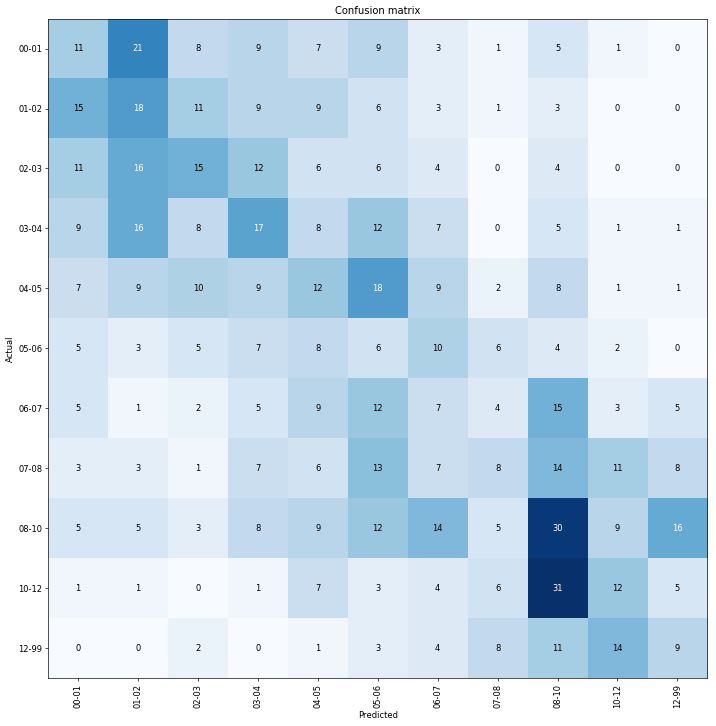

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


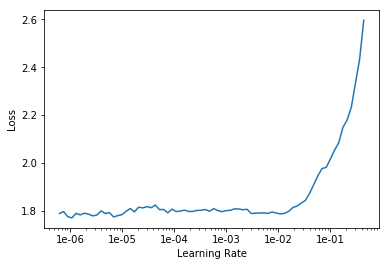

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(5e-6,5e-3))

epoch,train_loss,valid_loss,error_rate,time
0,2.291580,2.208258,0.822196,04:25
1,2.021907,2.116580,0.817422,04:24


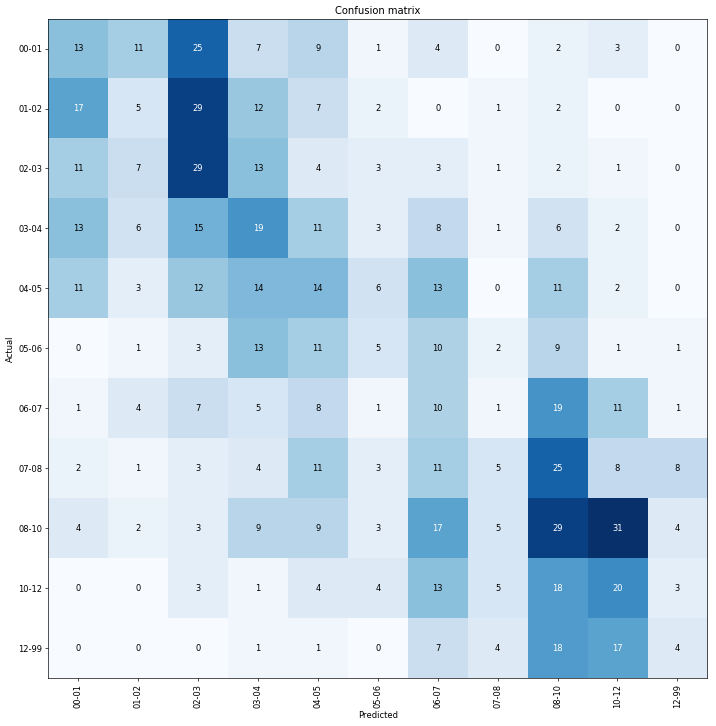

In [25]:
learn.save('model_spec_class_resnet34_unfreezed')

interp2 = ClassificationInterpretation.from_learner(learn)
interp2.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Regression

Note: range of MAE should be between 2.0 (excellent) and 2.2 (quite bad), for CV that takes groups of 20 x3-augmented-segments (i.e. 7 original segments, or 1.05M samples) as homogeneous buckets.

In [26]:
meta = pd.read_csv(BASE/'train_spec_meta.csv')
#data_class = data
#data = ImageDataBunch.from_df(TRAIN,  meta[['filename','time']], size=(128,293), bs=16)
data = (PointsItemList.from_df(meta[['filename','time']], TRAIN)
        .split_by_rand_pct(seed=42)
        .label_from_df(cols='time', label_cls=FloatList)
        .transform(size=(128,293))
        .databunch())
data.batch_size = 16
data

ImageDataBunch;

Train: LabelList (3356 items)
x: PointsItemList
Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293)
y: FloatList
1.4307972,1.3914989,1.3531961,1.3137978,1.2743995
Path: ..\Data\train_spec;

Valid: LabelList (838 items)
x: PointsItemList
Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293),Image (3, 128, 293)
y: FloatList
1.8439976,4.3518,5.6461983,1.2140988,5.1767983
Path: ..\Data\train_spec;

Test: None

In [27]:
class L1LossFlat(nn.L1Loss):
    '''Mean Absolute Error Loss'''
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

learn = cnn_learner(data, models.resnet34, loss_func=mean_absolute_error, metrics=mean_absolute_error)
learn.loss = L1LossFlat

In [28]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,mean_absolute_error,time
0,3.119612,2.549713,2.549713,03:11
1,2.458757,2.412488,2.412488,03:20
2,2.208898,2.330359,2.330359,03:11
3,2.150406,2.317212,2.317212,03:11


In [ ]:
learn.save('model_spec_reg_resnet34_freezed')

In [29]:
# TODO debug
#interp3 = ClassificationInterpretation.from_learner(learn)
#losses,idxs = interp3.top_losses()

TypeError: mean_absolute_error() got an unexpected keyword argument 'reduction'

In [1]:
df

NameError: name 'df' is not defined